In [134]:
import numpy as np
import pandas as pd 
import seaborn as sea 
import matplotlib.pyplot as plt

In [135]:
data = pd.read_csv('datasets/StudentPrediction/StudentPredictionReg.csv')

In [136]:
data.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12


In [137]:
data.shape

(649, 33)

In [138]:
conj = data.isna().nunique().reset_index()
conj.loc[conj[0]>1]

,index,0


Não há valores nulos

Selecionando os atributos categoricos binarios

In [139]:
subdataBin = data.select_dtypes(exclude=[np.int64, np.float64]).nunique().reset_index()
subdataBin = subdataBin.loc[subdataBin[0]<=2]
subdataBin.set_index('index').T

index,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,2,2,2,2,2,2,2,2,2,2,2,2,2


Selecionando os atributos categoricos 

In [140]:
subdataCat = data.select_dtypes(exclude=[np.int64, np.float64]).nunique().reset_index()
subdataCat = subdataCat.loc[ subdataCat[0]>2 ]
subdataCat.set_index('index').T

index,Mjob,Fjob,reason,guardian
0,5,5,4,3


Selecionando valores Numericos

In [141]:
subdataNum = data.select_dtypes(exclude=['string']).nunique().reset_index()
subdataNum = subdataNum.loc[ subdataNum[0]>2 ]
subdataNum.set_index('index').T

index,age,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,8,5,5,5,5,4,3,4,4,4,5,5,5,5,5,5,24,17,16,17


In [142]:
subdataNumC = data.select_dtypes(exclude=['string']).nunique().reset_index()
subdataNumC = subdataNumC.loc[ (subdataNumC[0] >= 4) & (subdataNumC[0] <= 5 )]
subdataNumC.set_index('index').T

index,Medu,Fedu,Mjob,Fjob,reason,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health
0,5,5,5,5,4,4,4,4,5,5,5,5,5,5


&nbsp;

### Correlação

In [152]:
from scipy.stats import chi2_contingency, pointbiserialr

class Correlation:
    M_ = None
    
    def __init__(self, column1:list, column2:list, data:pd.DataFrame):
        self.columnNames1 = column1
        self.columnNames2 = column2
        self.data         = data
        self.tupla        = ( len(self.columnNames1) , len(self.columnNames2) ) 

    def quiQuadrada(self):
        self.M_ = np.zeros(shape=self.tupla)
        
        for enumI, i in enumerate(self.columnNames1):
            for enumJ, j in enumerate(self.columnNames2):
                chi, p, _, _ = chi2_contingency( pd.crosstab(self.data[i].values, self.data[j].values) )
                self.M_[enumI,enumJ] = round(p,10)
        
        return pd.DataFrame(self.M_, columns=self.columnNames1, index=self.columnNames2)

    def pointBisserl(self):
        self.M_ = np.zeros(shape=self.tupla)
        for enumI, i in enumerate(self.columnNames1):
            for enumJ, j in enumerate(self.columnNames2):
                corr, p_value = pointbiserialr(self.data[i].values, self.data[j].values)
              
                self.M_[enumI, enumJ] = p_value
        return pd.DataFrame(self.M_.T, columns=self.columnNames1, index=self.columnNames2)

&nbsp;

## Pré processamento

In [153]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

Transformação de atributos

In [154]:
class TransformandoAtributosBin(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str):
        self.columns = columns
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        if (type(self.columns) == list):
            for column in self.columns:
                X[column] = LabelBinarizer().fit_transform(X[column])
        else:
            X[self.columns] = LabelBinarizer().fit_transform(X[self.columns].values)
        return X

In [155]:
class TransformandoAtributosEnc(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str):
        self.columns = columns

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        if (type(self.columns) == list):
            for column in self.columns:
                X[column] = LabelBinarizer().fit_transform(X[column])
        else:
            X[self.columns] = LabelEncoder().fit_transform(X[self.columns].values)
        return X

#### Pipeline

In [156]:
pipeline = Pipeline(
    steps=[
        ('Binarizer',TransformandoAtributosBin(columns=subdataBin['index'].to_list())),
        ('Encoder'  ,TransformandoAtributosEnc(columns=subdataCat['index'].to_list()))
    ]
)
dataset = pipeline.fit_transform(data)

#### Verificando correlação

In [157]:
cat = subdataBin['index'].tolist()+ subdataCat['index'].to_list()
corr = Correlation(cat,cat,dataset).quiQuadrada()

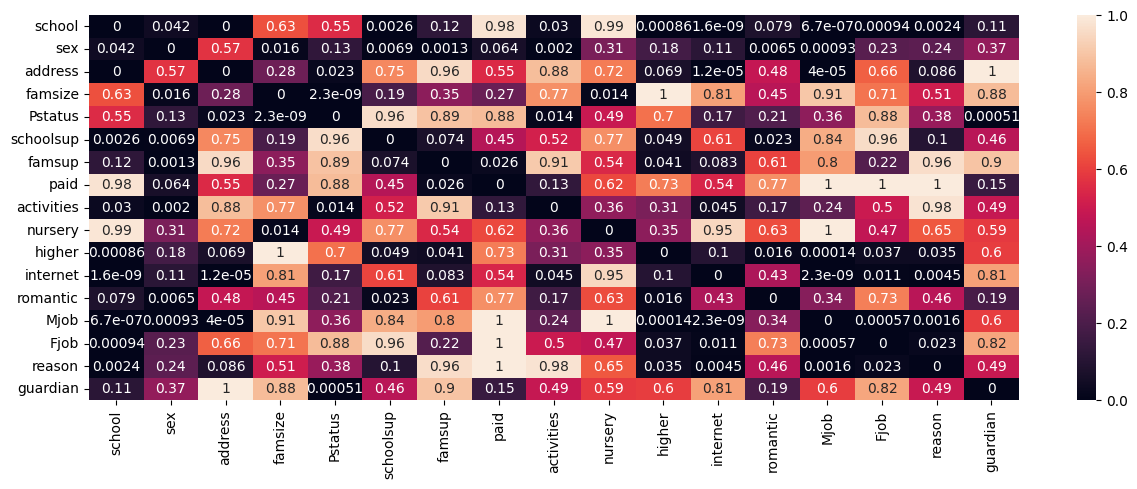

In [158]:
plt.figure(figsize=(15,5))
sea.heatmap(corr,annot=True) 
plt.show()